# Build a Retrieval Augmented Generation (RAG) App

One of the most powerful applications enabled by LLMs is sophisticated question-answering (Q&A) chatbots. These are applications that can answer questions about specific source information. These applications use a technique known as Retrieval Augmented Generation, or RAG.

This is a multi-part tutorial:
- Part 1 introduces RAG and walks through a minimal implementation.
- Part 2 extends the implementation to accommodate conversation-style interactions and multi-step retrieval processes.

This tutorial will show how to build a simple Q&A application over a text data source. Along the way we’ll go over a typical Q&A architecture and highlight additional resources for more advanced Q&A techniques. We’ll also see how LangSmith can help us trace and understand our application. LangSmith will become increasingly helpful as our application grows in complexity.

A typical RAG application has two main components:

**Indexing**: a pipeline for ingesting data from a source and indexing it. This usually happens offline.

**Retrieval and generation**: the actual RAG chain, which takes the user query at run time and retrieves the relevant data from the index, then passes that to the model.

# Indexing
1. Load: First we need to load our data. This is done with Document Loaders.
2. Split: Text splitters break large Documents into smaller chunks. This is useful both for indexing data and passing it into a model, as large chunks are harder to search over and won't fit in a model's finite context window.
3. Store: We need somewhere to store and index our splits, so that they can be searched over later. This is often done using a VectorStore and Embeddings model.
![Indexing](https://python.langchain.com/assets/images/rag_indexing-8160f90a90a33253d0154659cf7d453f.png)
# Retrieval and generation
4. Retrieve: Given a user input, relevant splits are retrieved from storage using a Retriever.
5. Generate: A ChatModel / LLM produces an answer using a prompt that includes both the question with the retrieved data
![Retrieval and generation](https://python.langchain.com/assets/images/rag_retrieval_generation-1046a4668d6bb08786ef73c56d4f228a.png)

In [1]:
pip install langchain

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

Note: you may need to restart the kernel to use updated packages.


# LangSmith
Many of the applications you build with LangChain will contain multiple steps with multiple invocations of LLM calls. As these applications get more complex, it becomes crucial to be able to inspect what exactly is going on inside your chain or agent. The best way to do this is with [LangSmith](https://smith.langchain.com/?_gl=1*1av1p9p*_ga*MTY4NjgwMTQ5NS4xNzU5NjAyMjc4*_ga_47WX3HKKY2*czE3NTk2Mzc4MDckbzMkZzEkdDE3NTk2Mzg4MjEkajYwJGwwJGgw)

After you sign up at the link above, make sure to set your environment variables to start logging traces:

In [3]:
# export LANGSMITH_TRACING="true"
# export LANGSMITH_API_KEY="..."

import getpass
from dotenv import load_dotenv
import os

load_dotenv()

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANG_SMITH_API_KEY")

# Components

We will need to select three components from LangChain's suite of integrations.

In [4]:
pip install -qU "langchain[google-genai]"

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install -qU langchain-openai

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install -qU langchain-astradb

Note: you may need to restart the kernel to use updated packages.


In [7]:
#model: Google Gemini
# Selecct chat model from LangChain's suite of integrations.
if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.5-flash", model_provider="google_genai")


In [8]:
#Select embedding model from LangChain's suite of integrations.
# Google gemini Embeddings

from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")


# OpenAI Embeddings
# if not os.environ.get("OPENAI_API_KEY"):
#   os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

# from langchain_openai import OpenAIEmbeddings

# embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [9]:
!pip install \
    "langchain>=0.3.23,<0.4" \
    "langchain-core>=0.3.52,<0.4" \
    "langchain-astradb>=0.6,<0.7"

In [10]:
#Select vector store
#astraDB
import os
from dotenv import load_dotenv
import os

load_dotenv()

ASTRA_DB_API_ENDPOINT = os.getenv("ASTRA_DB_API_ENDPOINT")
ASTRA_DB_APPLICATION_TOKEN = os.getenv("ASTRA_DB_APPLICATION_TOKEN")
ASTRA_DB_KEYSPACE = os.getenv("ASTRA_DB_KEYSPACE")

# desired_keyspace = input("(optional) ASTRA_DB_KEYSPACE = ").strip()
# if desired_keyspace:
#     ASTRA_DB_KEYSPACE = desired_keyspace
# else:
#     ASTRA_DB_KEYSPACE = None


from langchain_astradb import AstraDBVectorStore

vector_store = AstraDBVectorStore(
    embedding=embeddings,
    api_endpoint=ASTRA_DB_API_ENDPOINT,
    collection_name="astra_vector_langchain",
    token=ASTRA_DB_APPLICATION_TOKEN,
    namespace=ASTRA_DB_KEYSPACE,
)

# Overview
In this guide we’ll build an app that answers questions about the website's content. The specific website we will use is the [LLM Powered Autonomous Agents blog post by Lilian Weng](https://lilianweng.github.io/posts/2023-06-23-agent/), which allows us to ask questions about the contents of the post.

We can create a simple indexing pipeline and RAG chain to do this in ~50 lines of code.

In [11]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [12]:
# Then run the question-answering application
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])

Task Decomposition is the process of breaking down large, complex tasks into smaller, more manageable subgoals or steps. This technique, often used by LLMs through methods like Chain of Thought, enhances performance by simplifying complex problems. It can be achieved via LLM prompting, task-specific instructions, or human input.


# Details walkthrough
## Indexing
### 1. Loading Document
We need to first load the blog post contents. We can use [DocumentLoaders](https://python.langchain.com/docs/concepts/document_loaders/) for this, which are objects that load in data from a source and return a list of Document objects.

In this case we’ll use the [WebBaseLoader](https://python.langchain.com/docs/integrations/document_loaders/web_base/), which uses urllib to load HTML from web URLs and BeautifulSoup to parse it to text. We can customize the HTML -> text parsing by passing in parameters into the BeautifulSoup parser via bs_kwargs (see [BeautifulSoup docs](https://beautiful-soup-4.readthedocs.io/en/latest/#beautifulsoup)). In this case only HTML tags with class “post-content”, “post-title”, or “post-header” are relevant, so we’ll remove all others.

In [13]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43047


In [14]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


### 2. Splitting Document
Our loaded document is over 42k characters which is too long to fit into the context window of many models. Even for those models that could fit the full post in their context window, models can struggle to find information in very long inputs.

To handle this we’ll split the Document into chunks for embedding and vector storage. This should help us retrieve only the most relevant parts of the blog post at run time.

We use a [RecursiveCharacterTextSplitter](https://python.langchain.com/docs/how_to/recursive_text_splitter/), which will recursively split the document using common separators like new lines until each chunk is the appropriate size. This is the recommended text splitter for generic text use cases.

In [15]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 63 sub-documents.


### 3. Storing Document
Now we need to index our 63 text chunks so that we can search over them at runtime. Following the [semantic search tutorial](https://python.langchain.com/docs/tutorials/retrievers/), our approach is to embed the contents of each document split and insert these embeddings into a vector store. Given an input query, we can then use vector search to retrieve relevant documents.

We can embed and store all of our document splits in a single command using the vector store and embeddings model selected at the start of the tutorial.

In [16]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['bbbb3dce44bb461bafc40185b1d67f7e', '082646316761458095ddf2eb2687aae7', 'db72b5e9ad8f4cd0a418adbaad5909fd']


This completes the Indexing portion of the pipeline. At this point we have a query-able vector store containing the chunked contents of our blog post. Given a user question, we should ideally be able to return the snippets of the blog post that answer the question.

# Retrieval and Generation

Now let’s write the actual application logic. We want to create a simple application that takes a user question, searches for documents relevant to that question, passes the retrieved documents and initial question to a model, and returns an answer.

For generation, we will use the chat model selected at the [start of the tutorial](https://python.langchain.com/docs/tutorials/rag/#components).

We’ll use a prompt for RAG that is checked into the LangChain prompt hub ([here](https://smith.langchain.com/hub/rlm/rag-prompt?_gl=1*7mimhj*_ga*MTY4NjgwMTQ5NS4xNzU5NjAyMjc4*_ga_47WX3HKKY2*czE3NTk3NDYwOTgkbzYkZzEkdDE3NTk3NDYyMTQkajMxJGwwJGgw)).

In [18]:
from langchain import hub

# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


We'll use [LangGraph](https://langchain-ai.github.io/langgraph/?_gl=1*19uz26p*_ga*MTY4NjgwMTQ5NS4xNzU5NjAyMjc4*_ga_47WX3HKKY2*czE3NTk3NDYwOTgkbzYkZzEkdDE3NTk3NDYyMTQkajMxJGwwJGgw) to tie together the retrieval and generation step into a single application. This will bring a number of benefits:

- We can define our application logic once and automatically support multiple invocation modes, including streaming, async, and batched calls.
- We get streamlined deployments via [LangGraph Platform](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/?_gl=1*2vhqel*_ga*MTY4NjgwMTQ5NS4xNzU5NjAyMjc4*_ga_47WX3HKKY2*czE3NTk3NDYwOTgkbzYkZzEkdDE3NTk3NDYyMTQkajMxJGwwJGgw).
- LangSmith will automatically trace the steps of our application together.
- We can easily add key features to our application, including persistence and human-in-the-loop approval, with minimal code changes.

To use LangGraph, we need to define three things:
+ The state of application.
+ The nodes of application (i.e.., application steps).
+ The control flow of application (e.g.., the oderings of the steps).

**State**:
The state of application control what data input to the application, transferred between steps, and output by the application. It is typically a TypedDict, but can also be a [Pydantic BaseModel](https://langchain-ai.github.io/langgraph/how-tos/state-model/?_gl=1*2zuu9t*_ga*MTY4NjgwMTQ5NS4xNzU5NjAyMjc4*_ga_47WX3HKKY2*czE3NTk3NDYwOTgkbzYkZzEkdDE3NTk3NDYyMTQkajMxJGwwJGgw).

For a simple RAG application, we can just keep track of the input question, retrieved context, and generated answer:

In [19]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str 

**Nodes (Application Steps)**
Let't start with a simple sequence on two steps: retrieval and generation.


In [20]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

Our retrieval step simply runs a similarity search using the input question, and the generation step formats the retrieved context and original question into a prompt for the chat model.

**Control Flow**

Finally, we compile our application into a single graph object. In this case, we are just connecting the retrieval and generation steps into a single sequence.

In [21]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

LangGraph also comes with built-in utilities for visualizing the control flow of your application:

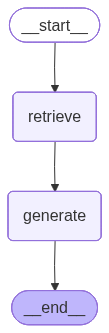

In [22]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

**Usage**

Invoke:

In [23]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(id='500379c894f94713a4457865a56dba98', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming the availabilit

Stream Step:

In [24]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='500379c894f94713a4457865a56dba98', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming

Stream tokens:

In [26]:
def format_token(token: str) -> str:
    """Format each token with separator"""
    return f"|{token}"

# Stream tokens with custom formatting
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, 
    stream_mode="messages"
):
    # Split content into tokens and format each one
    tokens = message.content.split()
    formatted_tokens = [format_token(token) for token in tokens]
    
    # Print each formatted token without newline
    for token in formatted_tokens:
        print(token, end="")
    print("||")  # Add final delimiter
    
# |Task| decomposition| is| the| process| of| breaking| down| complex| tasks| into| smaller|,| more| manageable| steps|.| It| can| be| achieved| through| techniques| like| Chain| of| Thought| (|Co|T|)| prompting|,| which| encourages| the| model| to| think| step| by| step|,| or| through| more| structured| methods| like| the| Tree| of| Thoughts|.| This| approach| not| only| simplifies| task| execution| but| also| provides| insights| into| the| model|'s| reasoning| process|.||

|Task|Decomposition|is|the|process|of|breaking|down|a|complicated|or|hard|task|into|smaller,|simpler,|and|more|manageable|steps|or|subgoals.|This|method|helps|agents|plan|ahead|and|enhances|performance|on|complex|tasks|by|transforming|them|into|multiple|manageable|parts.|It|can|be||
|achieved|through|Large|Language|Models|(LLMs)|with|simple|prompting,|task-specific|instructions,|or|human|inputs.||


Returning sources

Note that by storing the retrieved context in the state of the graph, we recover sources for the model's generated answer in the "context" field of the state.

**Customizing the prompt**

As shown above, we can load prompts (e.g., this RAG prompt) from the prompt hub. The prompt can also be easily customized. For example:

In [27]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

# Query analysis
So far, we are executing the retrieval using the raw input query. However, there are some advantages to allowing a model to generate the query for retrieval purposes. For example:
- In addition to semantic search, we can build in structured filters (e.g., "Find documents since the year 2020.");
- The model can rewrite user queries, which may be multifaceted or include irrelevant language, into more effective search queries.

[Query analysis](https://python.langchain.com/docs/concepts/retrieval/#query-analysis) employs models to transform or construct optimized search queries from raw user input. We can easily incorporate a query analysis step into our application. For illustrative purposes, let's add some metadata to the documents in our vector store. We will add some (contrived) sections to the document which we can filter on later.

In [28]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

We will need to update the documents in our vector store. We will use a simple InMemoryVectorStore for this, as we will use some of its specific features (i.e., metadata filtering). Refer to the vector store integration documentation for relevant features of your chosen vector store.


In [29]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

Let's next define a schema for our search query. We will use [structured output](https://python.langchain.com/docs/concepts/structured_outputs/) for this purpose. Here we define a query as containing a string query and a document section (either "beginning", "middle", or "end"), but this can be defined however you like.

In [30]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

Finally, we add a step to our LangGraph application to generate a query from the user's raw input:

In [31]:
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

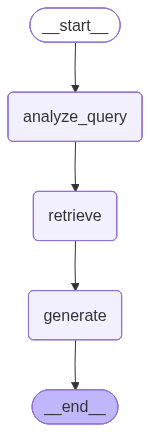

In [32]:
display(Image(graph.get_graph().draw_mermaid_png()))

We can test our implementation by specifically asking for context from the end of the post. Note that the model includes different information in its answer.

In [33]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='973b51f2-2481-419e-963b-74d7a04f3d16', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 38621, 'section': 'end'}, page_content='are imported by that file, and so on.\\nFollow a language and framework appropriate best practice file naming convention.\\nMake sure that files contain all imports, types etc. The code should be fully functional. Make sure that code in different files are compatible with each other.\\nBefore you finish, double check that all parts of the architecture is present in the files.\\n"'), Document(id='0e8cfe14-795a-43fa-85d3-7798bbfafd0c', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 34990, 'section': 'end'}, page_content='Conversatin samples:\n[\n  {\n    "role": "system",'), Document(id='8de427ba-60e7-42e7-bf7b-f1361cb12aca', metadata={'sourc

In both the streamed steps and the [LangSmith](https://smith.langchain.com/public/bdbaae61-130c-4338-8b59-9315dfee22a0/r?_gl=1*pp9aj6*_ga*MTY4NjgwMTQ5NS4xNzU5NjAyMjc4*_ga_47WX3HKKY2*czE3NTk3NzAwOTckbzckZzEkdDE3NTk3NzAxMTgkajM5JGwwJGgw) trace, we can now observe the structured query that was fed into the retrieval step.

Query Analysis is a rich problem with a wide range of approaches. Refer to the how-to guides for more examples.

# Next step
We've covered the steps to build a basic Q&A app over data:
- Loading data with a [Document Loader](https://python.langchain.com/docs/concepts/document_loaders/)
- Chunking the indexed data with a [Text Splitter](https://python.langchain.com/docs/concepts/text_splitters/) to make it more easily usable by a model
- [Embedding the data](https://python.langchain.com/docs/concepts/embedding_models/) and storing the data in a [vectorstore](https://python.langchain.com/docs/how_to/vectorstores/)
- [Retrieving](https://python.langchain.com/docs/concepts/retrievers/https://python.langchain.com/docs/concepts/retrievers/) the previously stored chunks in response to incoming questions.
- Generating an answer using the retrieved chunks as context.

Further reading:
- [Return sources](https://python.langchain.com/docs/how_to/qa_sources/): Learn how to return source documents
- [Streaming](https://python.langchain.com/docs/how_to/streaming/): Learn how to stream outputs and intermediate steps
- [Add chat history](https://python.langchain.com/docs/how_to/message_history/): Learn how to add chat history to your app
- [Retrieval conceptual guide](https://python.langchain.com/docs/concepts/retrieval/): A high-level overview of specific retrieval techniques